# Compton Scattering

In [10]:
# %load ../setup.py
"""
Packages for plotting and other stuff
version: 1.0
author: Riasat
"""
# %matplotlib widget

# data loading
import pandas as pd

# data maipulation
import pwlf
import numpy as np
from scipy.interpolate import interp1d

# plotting tools
import matplotlib.pyplot as plt

# extra tweaks
import warnings

warnings.filterwarnings("ignore")

# plot tweaks
plt.style.use("seaborn-poster")
pd.options.display.max_columns = None
pd.options.display.float_format = "{:.5f}".format

# function for extrapolation
def extrapolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(0, x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate2d(x, y):
    f = interp1d(x, y, kind="quadratic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate3d(x, y):
    f = interp1d(x, y, kind="cubic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# funciton for polynomial fitting
def polfit(a, b, c):
    z = np.polyfit(a, b, c)
    f = np.poly1d(z)

    x = np.arange(a[0], a[len(a) - 1], 0.001)
    y = f(x)
    return x, y


# function for picewise linear fit
def picewise_linear_fit(x, y, segments):
    my_pwlf = pwlf.PiecewiseLinFit(x, y)  # fit my data
    res = my_pwlf.fit(segments)  # fit the data for n line segments
    # slopes = myPWLF.calc_slopes()  # calculate slopes

    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = my_pwlf.predict(xHat)

    # calculate statistics
    # p = myPWLF.p_values(method="non-linear", step_size=1e-4)  # p-values
    # se = myPWLF.se  # standard errors
    return xHat, yHat


## Data

In [11]:
file_name = "data_scattering.xlsx"

# calibraton curve datas
data_calibration_curve = pd.read_excel(file_name, sheet_name="calibration curve")
original_calibration_channel = data_calibration_curve["channel"]
original_calibration_energy = data_calibration_curve["peak_energy"]
print(data_calibration_curve)

# scattering angle data
data_scattering = pd.read_excel(file_name, sheet_name="scattering angle")
original_angle = data_scattering["angle"]
original_peak = data_scattering["peak_channel"]
print(f"\n{data_scattering}")


   channel  counts  peak_energy
0     1050   34534      0.66200
1     1986    4691      1.17100
2     2277    3731      1.32200

   angle  peak_channel
0     15          1039
1     30           839
2     45           742
3     60           583
4     75           466
5     90           318
6    100           274
7    110           247


## Calibration Curve

the curve is between cesium-137 and cobalt-60

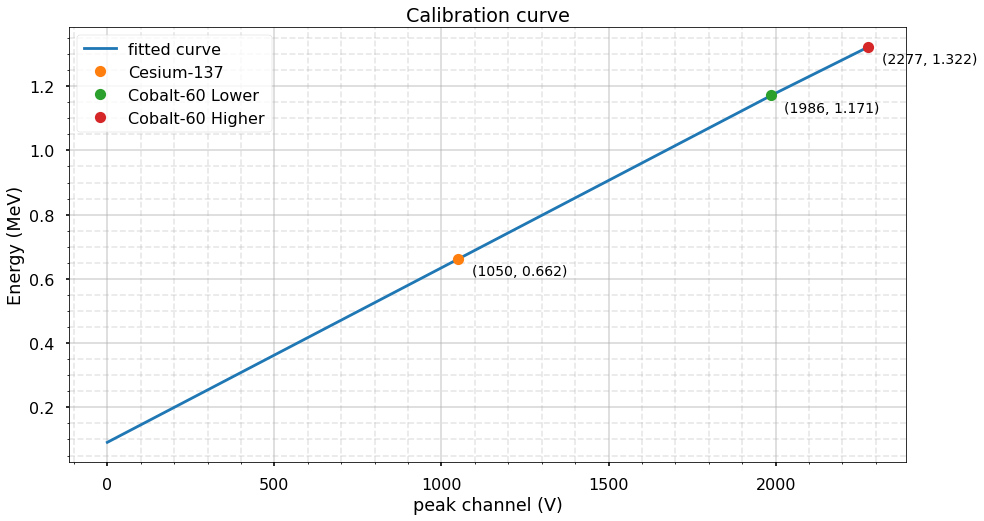

In [12]:
# extrapolated points
cal_chan_ext, cal_eng_ext = extrapolate1d(original_calibration_channel, original_calibration_energy)

# naming the elements
element_name = ["Cesium-137", "Cobalt-60 Lower", "Cobalt-60 Higher"]

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(f"Calibration curve")
plt.xlabel("peak channel (V)")
plt.ylabel("Energy (MeV)")
plt.plot(cal_chan_ext, cal_eng_ext, "-", label="fitted curve")
# plt.plot(original_calibration_channel, original_calibration_energy, "o", markersize=9, label="original channel")
for i in range(len(element_name)):
    plt.plot(
        original_calibration_channel[i], original_calibration_energy[i], "o", label=element_name[i]
    )
    plt.annotate(
        f"({original_calibration_channel[i]}, {original_calibration_energy[i]})",
        xy=(40 + original_calibration_channel[i], original_calibration_energy[i] - 0.05),
        fontsize=14,
    )

plt.legend(loc="upper left")
plt.grid(alpha=0.5, which="major")
plt.minorticks_on()
plt.grid(alpha=0.3, which="minor", ls="--")
plt.show()


## Scattering Angle

Theoretical vs Experimental differences

### Experimental

In [19]:
scattered_energy_expt = np.interp(original_peak, cal_chan_ext, cal_eng_ext)

data_scattering["energy expt"] = scattered_energy_expt
# print(data_scattering)


### Theoritical

In [14]:
#  energy of the original gamma ray in MeV
energy = original_calibration_energy[0]

# some constant used in the formula
mass_eqv = 0.511
const = energy / mass_eqv

# the scattering energy formula for compton scattering
costhetha = np.cos(np.deg2rad(original_angle))
cosine = 1 - costhetha
energy_prime = energy / (1 + const * cosine)  # scattered energy

# energy difference between theoritical and experimental
energy_diff = energy_prime - scattered_energy_expt

# adding them to the dataframe
data_scattering["energy theory"] = energy_prime
data_scattering["energy difference"] = abs(energy_diff)
print(f"constant = {const:3f}\n")
print(data_scattering)


constant = 1.295499

   angle  peak_channel  energy expt  energy theory  energy difference
0     15          1039      0.65602        0.63401            0.02201
1     30           839      0.54726        0.56409            0.01684
2     45           742      0.49451        0.47990            0.01460
3     60           583      0.40804        0.40176            0.00628
4     75           466      0.34442        0.33772            0.00670
5     90           318      0.26394        0.28839            0.02445
6    100           274      0.24001        0.26265            0.02264
7    110           247      0.22533        0.24173            0.01640


### Plot

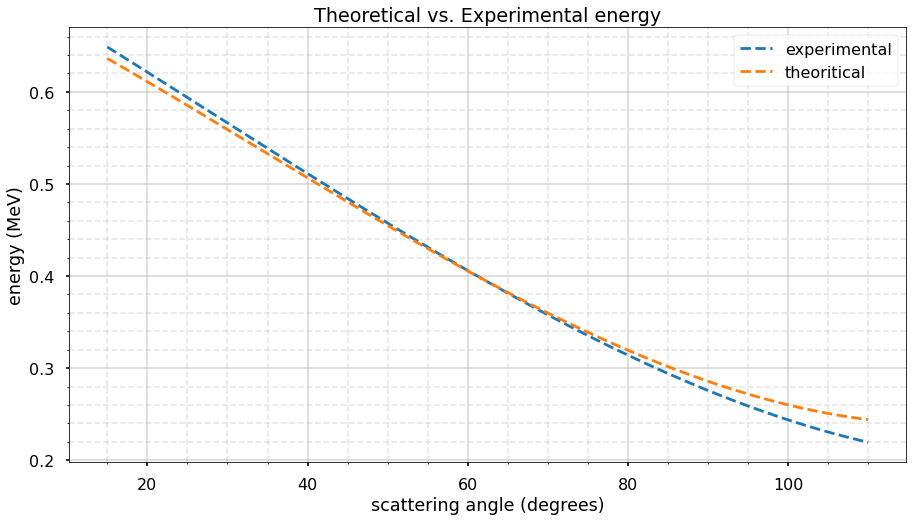

In [15]:
order = 3
angle_fitted1, expt_eng_fitted = polfit(original_angle, scattered_energy_expt, order)
angle_fitted2, theo_eng_fitted = polfit(original_angle, energy_prime, order)

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(f"Theoretical vs. Experimental energy")
plt.xlabel("scattering angle (degrees)")
plt.ylabel("energy (MeV)")
plt.plot(angle_fitted1, expt_eng_fitted, "--", label="experimental")
plt.plot(angle_fitted2, theo_eng_fitted, "--", label="theoritical")


# plt.plot(original_angle, scattered_energy_expt, "o", markersize=8, label="expt: og")
# plt.plot(original_angle, energy_prime, "k^", markersize=10, label="theo: og")
plt.legend(loc="upper right")
plt.grid(alpha=0.5, which="major")
plt.minorticks_on()
plt.grid(alpha=0.3, which="minor", ls="--")
plt.show()


## Linear Dependence

We need to check **"experimentally"** the linear dependence of inverse of the scattering energy with 1 - cosine of scattering angle

In [16]:
scattered_energy_expt_inv = 1 / scattered_energy_expt
polynomial = 1
cosine_fitted, scattered_energy_expt_inv_fitted = polfit(
    cosine, scattered_energy_expt_inv, polynomial
)

list_zip = list(zip(cosine, scattered_energy_expt_inv))
linear_data = pd.DataFrame(list_zip, columns=["cosine", "inverse energy"])
print(linear_data)


   cosine  inverse energy
0 0.03407         1.52435
1 0.13397         1.82729
2 0.29289         2.02221
3 0.50000         2.45072
4 0.74118         2.90344
5 1.00000         3.78880
6 1.17365         4.16652
7 1.34202         4.43802


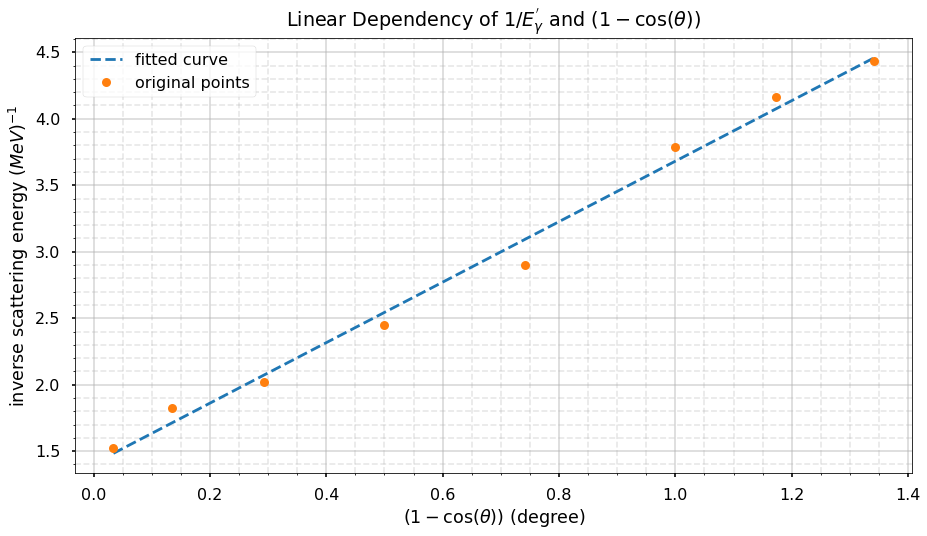

In [17]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(r"Linear Dependency of $1/E_\gamma^{'}$ and $(1 - \cos(\theta))$")
plt.xlabel(r"$(1-\cos(\theta))$ (degree)")
plt.ylabel(r"inverse scattering energy $(MeV)^{-1}$")
plt.plot(cosine_fitted, scattered_energy_expt_inv_fitted, "--", label="fitted curve")
plt.plot(cosine, scattered_energy_expt_inv, "o", markersize=9, label="original points")
plt.legend(loc="upper left")
plt.grid(alpha=0.5, which="major")
plt.minorticks_on()
plt.grid(alpha=0.3, which="minor", ls="--")
plt.show()
